In [2]:
import os
import numpy as np
from scipy.misc import imread, imresize, imsave
from random import shuffle
import tensorflow as tf
import matplotlib.pyplot as plt
#import glop
#import h5py

In [3]:
DATASET_DIR = 'Gaze_UPMC_Food20/images'
TRAIN_DIR = 'dataset/train_set/'
TEST_DIR = 'dataset/test_set/'

IMAGE_SIZE = 128
LR = 1e-4
CLASSES = 10
class_name = ['apple-pie', 'chocolate-cake', 'donuts', 'eggs-benedict', 'french-toast', 
              'gnocchi', 'grilled-salmon', 'pancakes', 'shrimp-and-grits', 'spaghetti-bolognese']


MODEL_NAME = 'Food-image-classifer-{}-{}-model'.format(LR, '2conv')

## Data Preparation

In [3]:
# lable the image
def label_img(index):
    label = [0 for _ in range(CLASSES)]
    label[index] = 1
    return label

In [4]:
# label train and test dataset and save them in numpy array
def create_dataset(path, dataset_name):
    dataset = []
    for index, img_dir_name in enumerate(sorted(os.listdir(path))):
        dir_path = os.path.join(path, img_dir_name)
        for img in os.listdir(dir_path):
            img_path = os.path.join(dir_path, img)
            img = imread(img_path)
            dataset.append((img, np.array(label_img(index))))
        shuffle(dataset)
        np.save(dataset_name + '.npy', dataset)

# Label train set
create_dataset(TRAIN_DIR, 'train_set')
# Label test set
create_dataset(TEST_DIR, 'test_set')

KeyboardInterrupt: 

## List images and label them

In [ ]:
shuffle_data = True  # shuffle the addresses before saving
hdf5_path = '/dataset/dataset.hdf5'  # address to where you want to save the hdf5 file
train_path = 'dataset/train_set/'
test_pat = 'dataset/test_set'

### Dataset Description

- dataset[]
   - num_images = 800, 10 class 0f each 80 images
   - 0 - img and 1 - label
   - img: 
       - [x, y, z] 
   - label:
       - [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]

### Helper function

In [6]:
def load_train():
    return np.load('dataset/train_set.npy')

def load_test():
    return np.load('dataset/test_set.npy')

### Training Datasets

In [7]:
train_set = load_train()

In [8]:
train_set.shape

(800, 2)

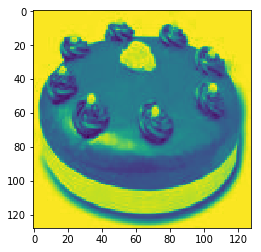

In [9]:
plt.imshow(train_set[0][0][:, :, 0])
plt.show()

In [10]:
train_X = np.array([i[0] for i in train_set]).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 3)
train_y = np.array([list(i[1]) for i in train_set]) 

In [11]:
print("Train_X shape: ", train_X.shape)
print("Train_y shape: ", train_y.shape)

Train_X shape:  (800, 128, 128, 3)
Train_y shape:  (800, 10)


In [12]:
# Load train batch
def train_batch(size=16):
    first_index,last_index = 0, size
    while last_index <= len(train_X):
        # print('First Index: ', first_index)
        # print('Last Index: ', last_index)
        yield train_X[first_index: last_index], train_y[first_index: last_index]
        first_index, last_index = last_index, last_index + size

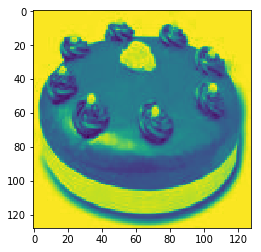

In [13]:
plt.imshow(train_X[0][:, :, 0])
plt.show()

In [14]:
class_name[np.argmax(train_y[0])]

'chocolate-cake'

### Testing Datasets

In [15]:
test_set = load_test()

In [16]:
test_set.shape

(200, 2)

In [17]:
test_X = np.array([i[0] for i in test_set]).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 3)
test_y = np.array([list(i[1]) for i in test_set]) 

In [18]:
print("Train_X shape: ", train_X.shape)
print("Train_y shape: ", train_y.shape)

Train_X shape:  (800, 128, 128, 3)
Train_y shape:  (800, 10)


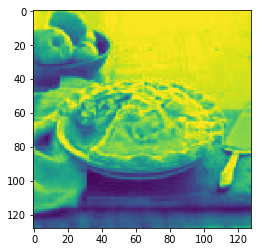

In [19]:
plt.imshow(test_X[0][:, :, 0])
plt.show()

In [20]:
class_name[np.argmax(test_y[0])]

'apple-pie'

## Place holder

In [28]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape=[None, IMAGE_SIZE, IMAGE_SIZE, 3], name='X')

In [29]:
y_true = tf.placeholder(tf.float32, shape=[None, CLASSES], name="y_true")
y_true_cls = tf.argmax(y_true, axis=1)

## CNN Model - Google Deep MNIST Architectuer

### Weight Initialization

In [30]:
def weight_variable(name, shape):
    W = tf.get_variable(name, shape,
           initializer=tf.contrib.layers.xavier_initializer())
    return W
how to remove old commited files from git
def bias_variable(shape):
    initial = tf.constant(0.5, shape=shape)
    return tf.Variable(initial)

### Convolution and Pooling

In [31]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding="SAME")

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], 
                          strides=[1, 2, 2, 1], padding="SAME")

In [32]:
# Frist Conv layer
W_conv1 = weight_variable('W_conv1', [5, 5, 3, 32])
b_conv1 = bias_variable([32])

h_conv1 = tf.nn.relu(conv2d(X, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# Second Conv Layer
W_conv2 = weight_variable('W_conv2', [5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# Third Conv Layer
W_conv3 = weight_variable('W_conv3', [5, 5, 64, 128])
b_conv3 = bias_variable([128])

h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
h_pool3 = max_pool_2x2(h_conv3)

print("h_pool3 shape: ", h_pool3.get_shape())

# Fully or Densely Connected Layer
W_fc1 = weight_variable('W_fc1', [16*16*128, 1024])
b_fc1 = bias_variable([1024])

h_pool3_flat = tf.reshape(h_pool3, [-1, 16*16*128])
h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, W_fc1) + b_fc1)

print("h_fc1 shape: ", h_fc1.get_shape())

# Dropout
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# Readout Layer
W_fc2 = weight_variable('W_fc2', [1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.add(tf.matmul(h_fc1_drop, W_fc2), b_fc2, name='y_conv')

print("y_conv shape: ", y_conv.get_shape())

h_pool3 shape:  (?, 16, 16, 128)
h_fc1 shape:  (?, 1024)
y_conv shape:  (?, 10)


### Training Model

In [33]:
# Feed forward - Prediction
y_pred = tf.nn.softmax(y_conv, name='y_pred')
y_pred_cls = tf.argmax(y_pred, axis=1, name='y_pred_cls')

# Training Objective
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=y_conv, labels=y_true)
#cost = tf.reduce_mean(cross_entropy)
train_step = tf.train.AdamOptimizer(LR).minimize(cross_entropy)

# Evaluation
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [34]:
saver = tf.train.Saver()

In [35]:
sess = tf.Session()

In [ ]:
counter = 0
sess.run(tf.global_variables_initializer())
for i in range(1000):
    for batch in train_batch():
        train_step.run(session=sess, feed_dict={X: batch[0], y_true: batch[1], keep_prob: 0.5})
    if i % 100 == 0:
        train_accuracy = accuracy.eval(session=sess, feed_dict={
                X: batch[0], y_true: batch[1], keep_prob: 1.0})
        print('step %d, training accuracy %g' % (i, train_accuracy))
        counter += 1
test_accuracy = accuracy.eval(session=sess, feed_dict={X: test_X, y_true: test_y, keep_prob: 1.0})
print("Test Accuracy: %g" % test_accuracy)

step 0, training accuracy 0.125


In [29]:
saver.save(sess, 'model/' + MODEL_NAME)

'model/Food-image-classifer-0.0001-2conv-model'

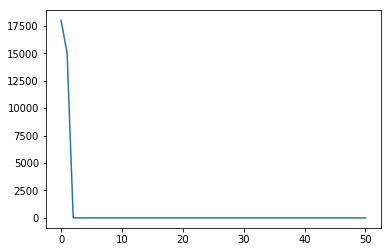

In [25]:
plt.plot(costs)
plt.show()